In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
df = pd.read_csv('20210109_dft_ml_redox_data.csv.gz', index_col=0)
df.head()

,smiles,ionization energy,electron affinity,pred ionization energy,pred electron affinity,err ionization energy,err electron affinity
0,C=C(CO)C1=C([CH]O)C(=O)C=C(C)C1=O,1.001039,NaN,0.944633,-0.206506,0.056406,NaN
1,C=C(O)C(=S)C1=C([CH]O)C(=O)CCC1=O,0.348169,0.325529,1.196336,-0.039882,0.848167,0.365411
2,C=C(CCO)C1=C([O])CCC=C1CCC,0.964468,-0.281083,1.045361,-0.254922,0.080893,0.026161
3,CCC=C(CN)C(CC)=C([O])C(C)(C)C,0.350509,-0.457001,0.886134,-0.435990,0.535625,0.021011
4,C=C(CCO)C([O])=C(C(C)C)C(C)(C)C,NaN,-0.221001,1.173760,-0.257057,NaN,0.036056


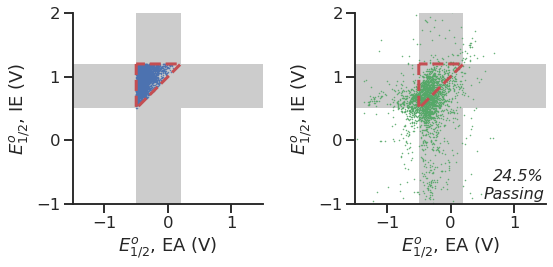

In [3]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(122, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df_pass = df[(df['electron affinity'] > -.5) &
        (df['ionization energy'] < 1.2) &
        (df['V_diff'] > 1)]

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

sns.despine()
plt.tight_layout()
plt.savefig('redox_dft_confirmation.svg')

In [4]:
df_pass.shape[0] / df.dropna(subset=['V_diff']).shape[0]

0.3176818950930626

In [5]:
df_spin = pd.read_csv('20210109_dft_ml_spin_bv_data.csv.gz')

In [6]:
import rdkit
import rdkit.Chem


In [7]:
def get_atom_symbols():
    for smiles in df_spin.smiles.unique():
        mol = rdkit.Chem.MolFromSmiles(smiles)
        for i, atom in enumerate(mol.GetAtoms()):
            yield pd.Series({
                'smiles': smiles,
                'atom_index': i,
                'atom_symbol': atom.GetSymbol()})

In [8]:
atom_symbol_df = pd.DataFrame(get_atom_symbols())

In [9]:
df_spin_symbol = df_spin.merge(atom_symbol_df, on=['smiles', 'atom_index'])

In [10]:
(df_spin_symbol.groupby('smiles').fractional_spin.idxmax() == df_spin_symbol.groupby('smiles')['pred fractional_spin'].idxmax()).mean()

0.8325718015665796

In [11]:
bur_vol_dft = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x.fractional_spin.idxmax()].buried_vol)
bur_vol_ml = df_spin_symbol.groupby('smiles').apply(lambda x: x.loc[x['pred fractional_spin'].idxmax()][' pred buried_vol'])

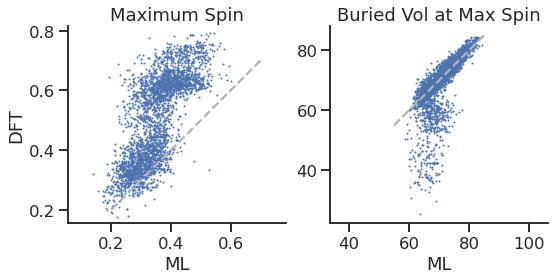

In [12]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121, aspect='equal', adjustable='datalim')

ax1.plot(
    df_spin_symbol.groupby('smiles')['pred fractional_spin'].max(),
    df_spin_symbol.groupby('smiles').fractional_spin.max(),
    '.', ms=2)

ax1.plot([.2, .7], [.2, .7], '--', color='.7')

ax2 = fig.add_subplot(122, aspect='equal', adjustable='datalim')
ax2.plot(bur_vol_ml, bur_vol_dft, '.', ms=2)

ax2.plot([55, 85], [55, 85], '--', color='.7')
ax1.set_ylabel('DFT')
ax1.set_xlabel('ML')
ax2.set_xlabel('ML')

ax1.set_title('Maximum Spin')
ax2.set_title('Buried Vol at Max Spin')


sns.despine()
plt.tight_layout()

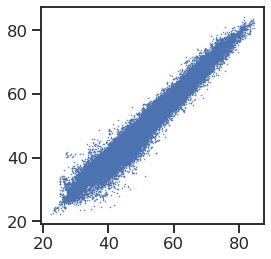

In [13]:
plt.figure(figsize=(4,4))
plt.plot(df_spin_symbol.buried_vol, df_spin_symbol[' pred buried_vol'], '.', ms=1)

In [14]:
def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    
    score_dft = bur_vol + 50 * (1 - spin)
    
    idxmax = x['pred fractional_spin'].idxmax()
    spin = x['pred fractional_spin'].max()
    bur_vol = x.loc[idxmax][' pred buried_vol']
    
    score_pred = bur_vol + 50 * (1 - spin)
    return pd.Series({'dft': score_dft, 'pred': score_pred})

stability_scores = df_spin_symbol.groupby('smiles').apply(stability_score)

In [15]:
redf_baseline = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/20210118_bde_baseline_spin_burvol.csv.gz')

def stability_score(x): 
    idxmax = x['fractional_spin'].idxmax()
    spin = x['fractional_spin'].max()
    bur_vol = x.loc[idxmax]['buried_vol']
    return bur_vol + 50 * (1 - spin)

bde_db_stability_scores = redf_baseline.groupby('smiles').apply(stability_score)

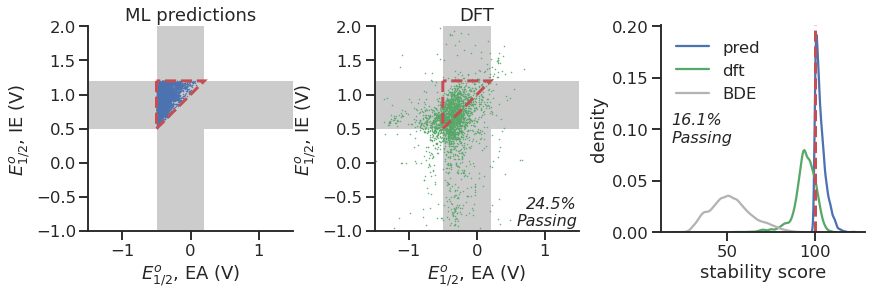

In [26]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131, aspect='equal')

ax1.plot(df['pred electron affinity'], df['pred ionization energy'], '.', ms=1, rasterized=True)
ax1.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1, 2])

ax1.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax1.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax1.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax1.set_ylabel(r'$E_{1/2}^o$, IE (V)')

ax2 = fig.add_subplot(132, aspect='equal')
ax2.plot(df['electron affinity'], df['ionization energy'], '.', ms=1, color='g', rasterized=True)
ax2.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1, 2])

ax2.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax2.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax2.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax2.set_ylabel(r'$E_{1/2}^o$, IE (V)')

df['V_diff'] = df['ionization energy'] - df['electron affinity']
df['pass_redox'] = ((df['electron affinity'] > -.5) &
                    (df['ionization energy'] < 1.2) &
                    (df['V_diff'] > 1))
df_pass = df[df.pass_redox]

df_with_stability = df.merge(stability_scores, left_on='smiles', right_index=True)

ax2.text(.99, .01, f'{df_pass.shape[0] / df.shape[0]:.1%}\nPassing', ha='right', va='bottom', transform=ax2.transAxes, fontsize='16', style='italic')

ax3 = fig.add_subplot(133)
sns.kdeplot(stability_scores['pred'], color='b')
sns.kdeplot(stability_scores['dft'], color='g')
sns.kdeplot(bde_db_stability_scores, color='.7', label='BDE')

ax3.axvline(100, ls='--', color='r', lw=3)
ax3.text(.05, .5, f"{(stability_scores['dft'] > 100).mean():.1%}\nPassing", ha='left', va='center', transform=ax3.transAxes, fontsize='16', style='italic')


plt.ylabel('density')
plt.xlabel('stability score')

ax1.set_title('ML predictions')
ax2.set_title('DFT')

sns.despine()
plt.tight_layout()
plt.savefig('redox_stability_dft_confirmation.svg')

In [17]:
df_confirmed = df_with_stability[df_with_stability['pass_redox'] & (df_with_stability.dft > 100)]

In [18]:
df_confirmed.to_csv('dft_confirmed.csv', index=False)

In [19]:
#import rdkit to draw the structures
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

In [20]:
df_confirmed

,smiles,ionization energy,electron affinity,pred ionization energy,pred electron affinity,err ionization energy,err electron affinity,V_diff,pass_redox,dft,pred
24,CC=C(CC)C1=C([O])CCC=C1CCC,0.805012,-0.452811,0.882655,-0.338538,0.077643,0.114273,1.257823,True,100.914523,104.992586
57,CCC(C)(C)C1=C([O])CCC=C1CO,0.720577,-0.429682,1.098930,-0.330799,0.378354,0.098883,1.150258,True,101.494737,105.344190
132,C#C[CH]C(C)=C(C(=O)O)C(C)(C)C,1.066046,-0.326035,1.108392,-0.402934,0.042346,0.076898,1.392081,True,103.010961,101.578032
201,C=C(C(=N)S)C1=C(CC)[CH]CCCC1=O,1.057583,-0.248158,1.096984,-0.264863,0.039401,0.016705,1.305741,True,103.036333,102.718756
208,NCC1=CC=CCC([O])=C1CCCO,0.878073,-0.179205,0.971913,-0.249113,0.093840,0.069908,1.057279,True,100.500263,101.795415
...,...,...,...,...,...,...,...,...,...,...,...
2782,CC(C)(O)C1=C([O])CCC=C1CCCO,0.776849,-0.403178,0.958913,-0.329907,0.182065,0.073271,1.180027,True,102.273856,105.534831
2883,CC=C(C)C1=C([O])CCC=C1C(C)C,0.870128,-0.495287,0.897680,-0.326110,0.027552,0.169177,1.365415,True,100.321284,100.895475
2891,CC=C(C)C1=C(CCS)[CH]CCC1=O,0.860821,-0.436212,0.767602,-0.461811,0.093219,0.025599,1.297034,True,101.922163,103.396725
2959,CC(C)=C(N=O)C1=C([CH]O)CCCC1=O,0.785638,-0.446471,0.794260,-0.299303,0.008622,0.147168,1.232108,True,100.296683,106.056034


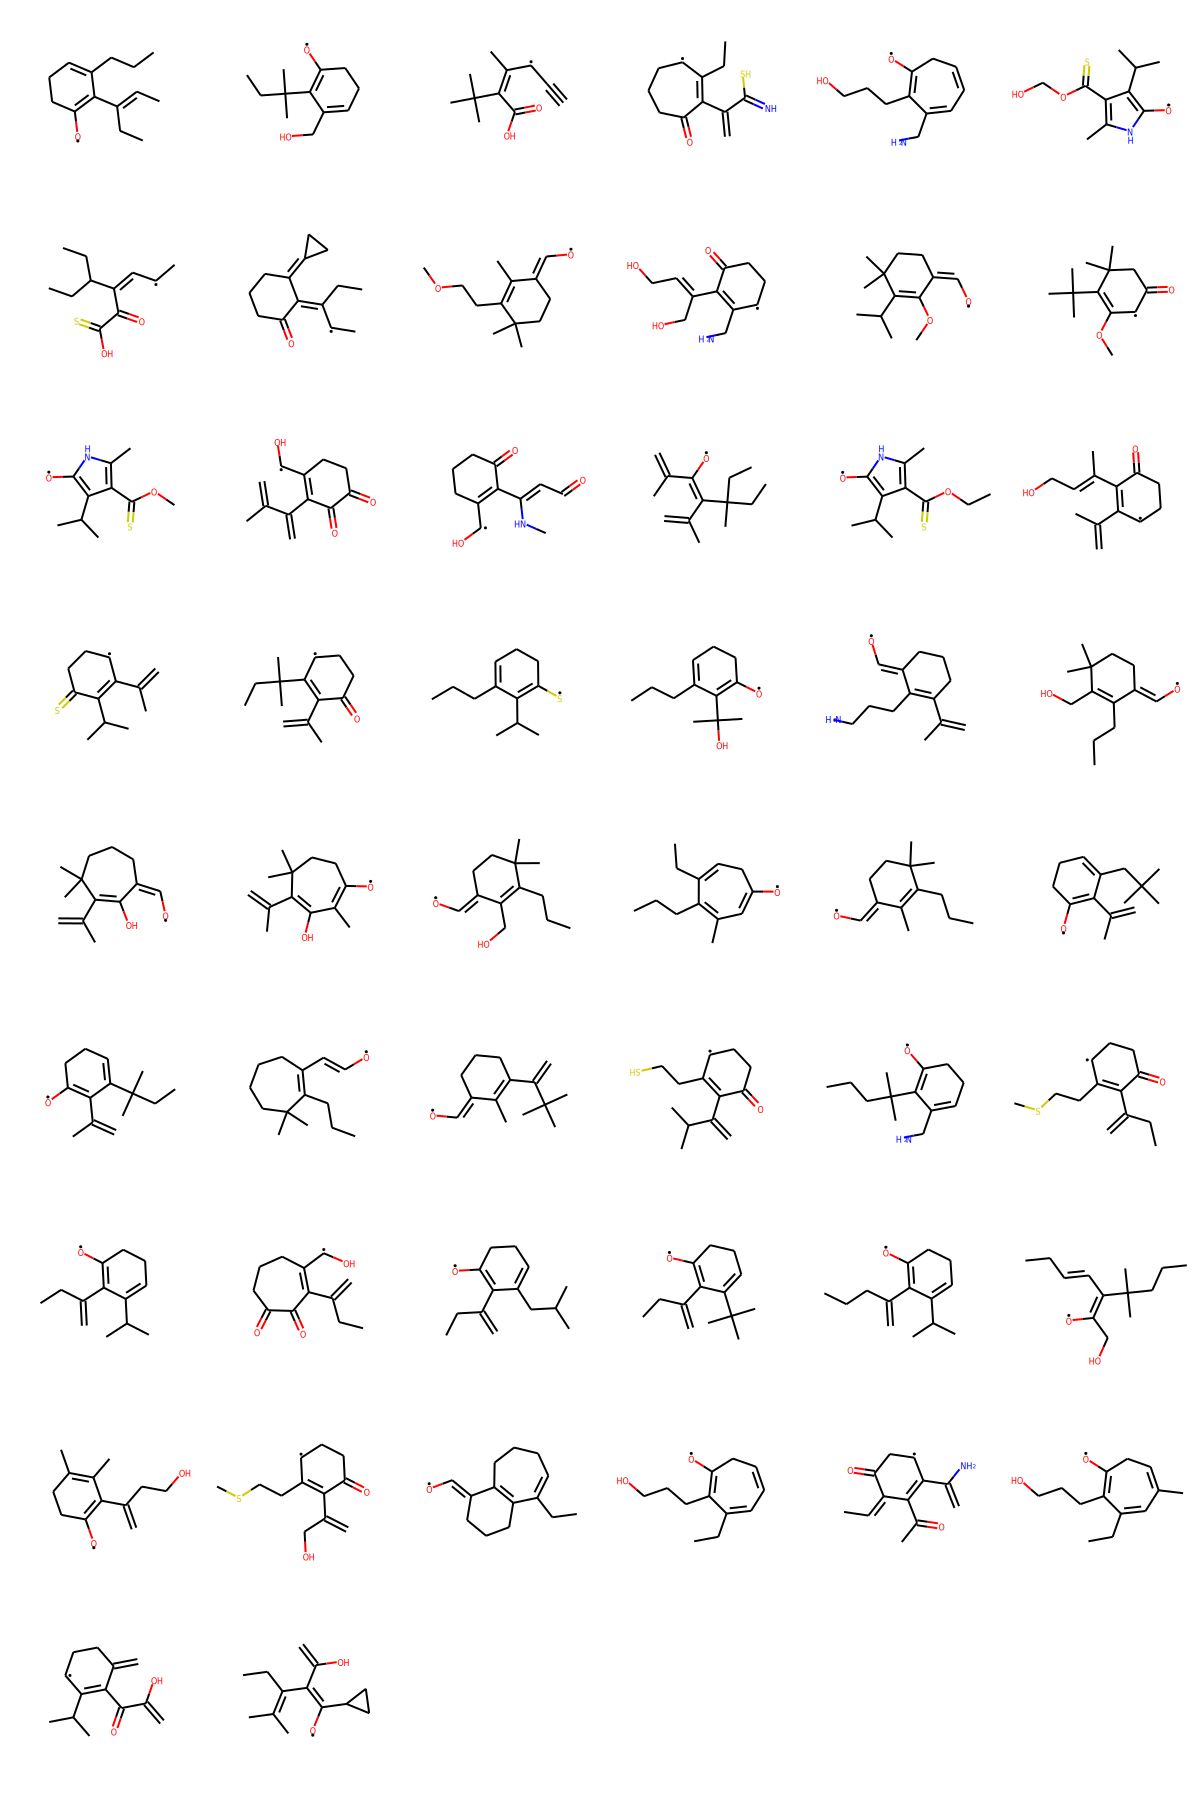

In [24]:
mols_out = df_confirmed.smiles.unique()
mol_objects_out = [Chem.MolFromSmiles(mol) for mol in mols_out]

Draw.MolsToGridImage(mol_objects_out, molsPerRow=6,subImgSize=(200, 200))

In [25]:
df_confirmed.smiles.nunique()

136